In [22]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN, AgglomerativeClustering
from scipy import stats
from statistics import mean
import os
from sklearn.metrics.pairwise import euclidean_distances
import math

# Get data from 10x

In [39]:
!wget https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor1/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz -P data/10x_donor1/
    

--2023-01-18 19:54:37--  https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor1/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 188.114.98.236, 188.114.99.236, 2a06:98c1:3122:e000::c, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|188.114.98.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 296410621 (283M) [application/x-tar]
Saving to: ‘data/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz’

vdj_v1_hs_aggregate 100%[===================>] 282.68M  3.50MB/s    in 2m 51s  

2023-01-18 19:57:28 (1.66 MB/s) - ‘data/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz’ saved [296410621/296410621]



In [83]:
!wget https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor1/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv -P data/10x_donor1/

--2023-01-19 07:51:15--  https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor1/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 188.114.98.236, 188.114.99.236, 2a06:98c1:3122:e000::c, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|188.114.98.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33851101 (32M) [text/csv]
Saving to: ‘data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv’

vdj_v1_hs_aggregate 100%[===================>]  32.28M  6.81MB/s    in 4.7s    

2023-01-19 07:51:22 (6.81 MB/s) - ‘data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv’ saved [33851101/33851101]



In [41]:
!gunzip data/10x_donor1/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz

In [43]:
!tar -xvf data/10x_donor1/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar -C data/

filtered_feature_bc_matrix/
filtered_feature_bc_matrix/matrix.mtx.gz
filtered_feature_bc_matrix/features.tsv.gz
filtered_feature_bc_matrix/barcodes.tsv.gz


In [45]:
!gunzip data/10x_donor1/filtered_feature_bc_matrix/matrix.mtx.gz
!gunzip data/10x_donor1/filtered_feature_bc_matrix/features.tsv.gz
!gunzip data/10x_donor1/filtered_feature_bc_matrix/barcodes.tsv.gz

# Code

In [23]:
def read_barcodes(barcodes_file):
    barcodes = pd.read_csv(barcodes_file, sep = '\t',header = None)
    barcodes.columns = ['barcode']
    barcodes.index += 1
    barcodes['barcode_id'] = barcodes.index
    return barcodes

def read_features(features_file):
    features = pd.read_csv(features_file, sep = '\t',header = None)
    features.index += 1
    features.columns = ['feature_code','value','type']
    features['feature_id'] = features.index
    features['feature_id'] = pd.to_numeric(features['feature_id'])
    return features

def read_matrix(matrix_file):
    matrix = pd.read_csv(matrix_file,sep = '\t')
    matrix = matrix.drop([0])
    matrix[['feature_id','barcode_id', 'count']] = matrix['%%MatrixMarket matrix coordinate integer general'].str.split(expand=True)
    matrix = matrix.drop(['%%MatrixMarket matrix coordinate integer general'], axis = 1)
    matrix = matrix.apply(pd.to_numeric)
    matrix['count']=matrix['count'].astype(int)
    return matrix

def merge_matrix(matrix,barcodes,features):
    matrix = pd.merge(matrix, barcodes, on="barcode_id")
    matrix = pd.merge(matrix, features, on="feature_id")
    #matrix = matrix.drop(['barcode_id','feature_id'],axis=1)
    return matrix


def get_value_matrix(matrix):
    v_t = matrix['value'].str.split('_',n=1,expand=True)
    matrix['value']=v_t[0]
    matrix['value_type']=v_t[1]
    return matrix

def get_tetramer_matrix(matrix):
    matrix = matrix.sort_values(by=['count'],ascending=False)
    tetramers = matrix.drop_duplicates('barcode')
    tetramers = tetramers[tetramers['count']>5]
    tetramers['tetramer'] = tetramers['value']
    tetramers =  tetramers[['barcode_id','tetramer']]
    matrix = pd.merge(matrix, tetramers, on="barcode_id")
    return matrix[['barcode','value','tetramer','count']]



In [200]:
def prep_annot_data(data):
    data_c = data[data['is_cell']==True].reset_index(drop=True)
    data_c = data_c[data_c['chain'] == "TRB"]
    
    data_c = data_c[-data_c['v_gene'].isna()]
    data_c = data_c[-data_c['j_gene'].isna()]
    
    data_c = data_c[-data_c['cdr3'].isna()]
    #data_no_10x = data_no_10x[-data_no_10x['antigen.epitope'].isna()]
    data_c = data_c[-data_c['v_gene'].str.contains(',')]
    data_c = data_c[-data_c['j_gene'].str.contains(',')]
    data_c = data_c[-data_c['cdr3'].str.contains('\*')]
    return data_c

def merge_anot_matrix_prev(data_c,matrix):
    data_c = pd.merge(data_c,matrix, on='barcode')
    data_c = data_c[['cdr3','count','tetramer','value','barcode']]
    data_c = data_c[data_c['cdr3']!='None']

def merge_anot_matrix(data_c,matrix):
    data_c = pd.merge(data_c,matrix, on=['barcode','tetramer'])
    data_c = data_c[['cdr3','count','tetramer','value','barcode']]
    data_c = data_c[data_c['cdr3']!='None']
    return data_c


def merge_anot_matrix_full_table(data_c,matrix):
    data_c = pd.merge(data_c,matrix, on='barcode')
    #data_c = data_c[['cdr3','count','tetramer','value','barcode']]
    data_c = data_c[data_c['cdr3']!='None']
    return data_c

### Normalization code

In [25]:
def sum_counts(data, cell_col_name, count_col_name, cell):
    return sum(data[data[cell_col_name]==cell][count_col_name])

def norm_logp_with_total_average(data, cell_id_col, count_col):
    # total count for cell
    cell_all_counts = pd.DataFrame(data[cell_id_col].drop_duplicates())
    cell_all_counts['counts']= cell_all_counts[cell_id_col].apply(lambda x: sum_counts(data_c_all,cell_id_col,count_col,x))
    
    cell_all_counts_dict = pd.Series(cell_all_counts['counts'].values,index=cell_all_counts[cell_id_col]).to_dict()
    ## average total count for cell
    average_total_count = cell_all_counts['counts'].mean()
    ## normalize log(1 + count / (total count for cell) * (average total count for cell)) 
    data['count']= data.apply(lambda row : math.log(1 + row[count_col]/cell_all_counts_dict[row[cell_id_col]]*average_total_count),axis=1)
    return data
    
    
def norm_logp(data, count_col):
    data[count_col]= data[count_col].apply(lambda x : math.log1p(x))
    return data
    

### Pivot code

In [26]:
def pivot_data_old(data):
    data = data[['count','cdr3','value']]
    data = data.pivot_table('count','cdr3','value')
    data = data.fillna(0)
    return data

In [27]:
def pivot_data(data):
    data = data[['count','barcode','value']]
    data = data.pivot_table('count','barcode','value')
    data = data.fillna(0)
    return data

### PCA code

In [28]:
def pca(data, n):
    
    if type(n) == int:
        x = StandardScaler().fit_transform(data)
        pca = PCA(n_components = n )
        principalComponents = pca.fit_transform(x)
        df_pca = pd.DataFrame(data = principalComponents)
        return df_pca, pca
        
    else:
        return data, pca

### TSNE code

In [29]:
def tsne(data,n,random_s,p):
    if type(n) == int:
        X_embedded = TSNE(n_components=n,init='pca',
                         random_state=random_s, perplexity=p).fit_transform(data)
        return X_embedded

## Reading and processing raw data

In [270]:
barcodes = read_barcodes('data/10x_donor1/filtered_feature_bc_matrix/barcodes.tsv')
features = read_features('data/10x_donor1/filtered_feature_bc_matrix/features.tsv')
matrix = read_matrix('data/10x_donor1/filtered_feature_bc_matrix/matrix.mtx')
matrix = merge_matrix(matrix,barcodes,features)
matrix = get_value_matrix(matrix)

matrix = matrix[matrix['type']=='Antibody Capture']
matrix = matrix[matrix['value_type']!='TotalSeqC']
matrix_t = get_tetramer_matrix(matrix)

KeyboardInterrupt: 

In [31]:
matrix_t.size

819904

In [32]:
matrix_t.head(5)

barcode      value   tetramer     count
0  TTTGTCATCAGGTAAA-40  AAKGRGAAL  AAKGRGAAL  76112470
1  TTTGTCATCAGGTAAA-40  QYDPVAALF  AAKGRGAAL         2
2  TTTGTCATCAGGTAAA-40  KLGGALQAK  AAKGRGAAL         1
3  TTTGTCATCAGGTAAA-40  NLVPMVATV  AAKGRGAAL         1
4  TTTGTCATCAGGTAAA-40  QPRAPIRPI  AAKGRGAAL         1

In [201]:
data_annot_preped = pd.read_csv('data_scripts/data_annot_preped.txt', sep='\t')

### KLG is already excluded in data_annot_preped

In [208]:
#data = pd.read_csv("data/10x_donor1/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv", sep = ',')
#data_c_annot = prep_annot_data(data)
#data_c = data_c_annot.copy()

data_annot_preped = pd.read_csv('data_scripts/data_annot_preped.txt', sep='\t')
##using universal annot data with tcr-emb
data_c = data_annot_preped.drop(['count'],axis=1).copy()
data_c_full = merge_anot_matrix_full_table(data_c,matrix_t)
data_c = merge_anot_matrix(data_c,matrix_t)
data_c['count'].mean()

628.4410621245678

In [265]:
data_c

cdr3  count    tetramer       value              barcode
0       CASSLYSATGELFF    451  AVFDRKSDAK  AVFDRKSDAK  AAACCTGAGATTACCC-16
1       CASSLYSATGELFF      4  AVFDRKSDAK   KLGGALQAK  AAACCTGAGATTACCC-16
2       CASSLYSATGELFF      3  AVFDRKSDAK   GPAESAAGL  AAACCTGAGATTACCC-16
3       CASSLYSATGELFF      2  AVFDRKSDAK   QPRAPIRPI  AAACCTGAGATTACCC-16
4       CASSLYSATGELFF      2  AVFDRKSDAK   GILGFVFTL  AAACCTGAGATTACCC-16
...                ...    ...         ...         ...                  ...
125517   CASSTSNEQPQHF      5   GILGFVFTL  AVFDRKSDAK  TTTGTCATCGAGGTAG-13
125518  CASSTGAGVNEQYF     14  AVFDRKSDAK  AVFDRKSDAK  TTTGTCATCTCCTATA-36
125519  CASSTGAGVNEQYF      4  AVFDRKSDAK   KLGGALQAK  TTTGTCATCTCCTATA-36
125520  CASSTGAGVNEQYF      3  AVFDRKSDAK   RLRAEAQVK  TTTGTCATCTCCTATA-36
125521  CASSTGAGVNEQYF      2  AVFDRKSDAK   IVTDFSVIK  TTTGTCATCTCCTATA-36

[125522 rows x 5 columns]

In [66]:
data_c_full_grouped = data_c_full[['barcode','contig_id','chain','v_gene','d_gene','j_gene','cdr3','tetramer']]
data_c_full_grouped = data_c_full_grouped.drop_duplicates()

In [67]:
data_c_full_grouped['cdr3'].drop_duplicates()

0            CATSRDRGHGDTIYF
6             CASSLYSATGELFF
20         CASSPGAPRSGANVLTF
57           CASSWGGGSHYGYTF
108       CASGYWKLAGGPQETQYF
                 ...        
353962         CASSSGRSTEAFF
353977       CASSPHPTGGRGYTF
353998         CASSLPGSYEQYF
354003         CASSTSNEQPQHF
354009        CASSTGAGVNEQYF
Name: cdr3, Length: 7770, dtype: object

In [68]:
data_c_full_grouped[['barcode','cdr3']].drop_duplicates()

barcode               cdr3
0       AAACCTGAGAGTGAGA-23    CATSRDRGHGDTIYF
6       AAACCTGAGATTACCC-16     CASSLYSATGELFF
20      AAACCTGAGGCTCATT-34  CASSPGAPRSGANVLTF
57      AAACCTGAGGGAGTAA-40    CASSWGGGSHYGYTF
82      AAACCTGAGGGAGTAA-40     CASSLYSATGELFF
...                     ...                ...
353991  TTTGTCATCCGAAGAG-35       CSASPGDYEQYF
353998  TTTGTCATCCTATGTT-26      CASSLPGSYEQYF
354003  TTTGTCATCGAGGTAG-13      CASSTSNEQPQHF
354009  TTTGTCATCTCCTATA-36     CASSTGAGVNEQYF
354013  TTTGTCATCTGTCAAG-32   CASSLGASRSTDTQYF

[23893 rows x 2 columns]

In [69]:
data_c_full_grouped[['tetramer','cdr3']].drop_duplicates()

tetramer               cdr3
0        KLGGALQAK    CATSRDRGHGDTIYF
6       AVFDRKSDAK     CASSLYSATGELFF
20       KLGGALQAK  CASSPGAPRSGANVLTF
57       IVTDFSVIK    CASSWGGGSHYGYTF
82       IVTDFSVIK     CASSLYSATGELFF
...            ...                ...
353962   KLGGALQAK      CASSSGRSTEAFF
353977   AAKGRGAAL    CASSPHPTGGRGYTF
353998   KLGGALQAK      CASSLPGSYEQYF
354003   GILGFVFTL      CASSTSNEQPQHF
354009  AVFDRKSDAK     CASSTGAGVNEQYF

[8956 rows x 2 columns]

In [209]:
data_c['count'].median()

2.0

In [210]:
data_c_all = data_c.copy()

In [211]:
data_c_all_dedup = data_c_all.drop_duplicates(['cdr3','tetramer','barcode'])
data_c_all_dedup

cdr3     count    tetramer       value              barcode
0        CASSLYSATGELFF       451  AVFDRKSDAK  AVFDRKSDAK  AAACCTGAGATTACCC-16
14      CASSWGGGSHYGYTF       458   IVTDFSVIK   IVTDFSVIK  AAACCTGAGGGAGTAA-40
39       CASSLYSATGELFF        83  AVFDRKSDAK  AVFDRKSDAK  AAACCTGAGGTGCACA-13
40      CASTDFGSGANVLTF        45   GILGFVFTL   GILGFVFTL  AAACCTGAGTGGGTTG-17
42      CASSWGGGSHYGYTF       206   IVTDFSVIK   IVTDFSVIK  AAACCTGAGTTTAGGA-39
...                 ...       ...         ...         ...                  ...
125500  CASSPRDRERGEQYF        12  AVFDRKSDAK  AVFDRKSDAK  TTTGTCAGTGATAAGT-22
125507   CAWVLGPAGDTQYF         8  AVFDRKSDAK  AVFDRKSDAK  TTTGTCAGTTACCGAT-20
125511  CASSPHPTGGRGYTF  76112470   AAKGRGAAL   AAKGRGAAL  TTTGTCATCAGGTAAA-40
125516    CASSTSNEQPQHF        67   GILGFVFTL   GILGFVFTL  TTTGTCATCGAGGTAG-13
125518   CASSTGAGVNEQYF        14  AVFDRKSDAK  AVFDRKSDAK  TTTGTCATCTCCTATA-36

[12756 rows x 5 columns]

In [212]:
v_param = '280623'
data_c_all_path = 'data_scripts/10x_tetramer_annot' + v_param + '.txt'
matrix_path = 'data_scripts/10x_tetramer_matrix' + v_param + '.txt'
data_c_all.to_csv(data_c_all_path, sep='\t', index = False)
matrix_t.to_csv(matrix_path, sep='\t', index = False)

# Analysis

In [301]:
v_param = '280623'
data_c_all_path = 'data_scripts/10x_tetramer_annot' + v_param + '.txt'
matrix_path = 'data_scripts/10x_tetramer_matrix' + v_param + '.txt'

In [302]:
data_c_all = pd.read_csv(data_c_all_path, sep='\t')
data_c_all.head(5)

cdr3  count    tetramer       value              barcode
0  CASSLYSATGELFF    451  AVFDRKSDAK  AVFDRKSDAK  AAACCTGAGATTACCC-16
1  CASSLYSATGELFF      4  AVFDRKSDAK   KLGGALQAK  AAACCTGAGATTACCC-16
2  CASSLYSATGELFF      3  AVFDRKSDAK   GPAESAAGL  AAACCTGAGATTACCC-16
3  CASSLYSATGELFF      2  AVFDRKSDAK   QPRAPIRPI  AAACCTGAGATTACCC-16
4  CASSLYSATGELFF      2  AVFDRKSDAK   GILGFVFTL  AAACCTGAGATTACCC-16

In [303]:
matrix_t = pd.read_csv(matrix_path, sep='\t')
matrix_t.head(5)

barcode      value   tetramer     count
0  TTTGTCATCAGGTAAA-40  AAKGRGAAL  AAKGRGAAL  76112470
1  TTTGTCATCAGGTAAA-40  QYDPVAALF  AAKGRGAAL         2
2  TTTGTCATCAGGTAAA-40  KLGGALQAK  AAKGRGAAL         1
3  TTTGTCATCAGGTAAA-40  NLVPMVATV  AAKGRGAAL         1
4  TTTGTCATCAGGTAAA-40  QPRAPIRPI  AAKGRGAAL         1

### logP normalization

Нормировка logp
Без отсечки по кайнтам

In [305]:

data_c_n = norm_logp(data_c_all, 'count')
barcode_tetramer = data_c_n[['barcode','tetramer']].drop_duplicates()
data_c_p = pivot_data(data_c_n)

In [306]:
data_c_p

value                AAKGRGAAL  ALIAPVHAV  AVFDRKSDAK  AYAQKIFKI  AYSSAGASI  \
barcode                                                                       
AAACCTGAGATTACCC-16   0.000000   0.693147    6.113682        0.0   0.693147   
AAACCTGAGGGAGTAA-40   0.693147   1.098612    5.192957        0.0   0.000000   
AAACCTGAGGTGCACA-13   0.000000   0.000000    4.430817        0.0   0.000000   
AAACCTGAGTGGGTTG-17   0.000000   0.000000    0.000000        0.0   0.000000   
AAACCTGAGTTTAGGA-39   0.000000   0.000000    1.386294        0.0   0.000000   
...                        ...        ...         ...        ...        ...   
TTTGTCAGTGATAAGT-22   0.000000   0.000000    2.564949        0.0   0.000000   
TTTGTCAGTTACCGAT-20   0.000000   0.000000    2.197225        0.0   0.000000   
TTTGTCATCAGGTAAA-40  18.147723   0.000000    0.000000        0.0   0.000000   
TTTGTCATCGAGGTAG-13   0.000000   0.000000    1.791759        0.0   0.000000   
TTTGTCATCTCCTATA-36   0.000000   0.000000    2.708050        0.0   0.000000   

value                CLGGLLTMV  CLLGTYTQDV  CLLWSFQTSA  CYTWNQMNL  ELAGIGILTV  \
barcode                                                                         
AAACCTGAGATTACCC-16        0.0         0.0         0.0        0.0    0.693147   
AAACCTGAGGGAGTAA-40        0.0         0.0         0.0        0.0    0.000000   
AAACCTGAGGTGCACA-13        0.0         0.0         0.0        0.0    0.000000   
AAACCTGAGTGGGTTG-17        0.0         0.0         0.0        0.0    0.000000   
AAACCTGAGTTTAGGA-39        0.0         0.0         0.0        0.0    0.000000   
...                        ...         ...         ...        ...         ...   
TTTGTCAGTGATAAGT-22        0.0         0.0         0.0        0.0    0.000000   
TTTGTCAGTTACCGAT-20        0.0         0.0         0.0        0.0    0.000000   
TTTGTCATCAGGTAAA-40        0.0         0.0         0.0        0.0    0.000000   
TTTGTCATCGAGGTAG-13        0.0         0.0         0.0        0.0    0.000000   
TTTGTCATCTCCTATA-36        0.0         0.0         0.0        0.0    0.000000   

value                ...  SLEGGGLGY  SLFNTVATL  SLFNTVATLY  SLLMWITQV  \
barcode              ...                                                
AAACCTGAGATTACCC-16  ...        0.0   0.693147         0.0   0.000000   
AAACCTGAGGGAGTAA-40  ...        0.0   0.000000         0.0   0.693147   
AAACCTGAGGTGCACA-13  ...        0.0   0.000000         0.0   0.000000   
AAACCTGAGTGGGTTG-17  ...        0.0   0.000000         0.0   0.000000   
AAACCTGAGTTTAGGA-39  ...        0.0   0.000000         0.0   0.000000   
...                  ...        ...        ...         ...        ...   
TTTGTCAGTGATAAGT-22  ...        0.0   0.000000         0.0   0.000000   
TTTGTCAGTTACCGAT-20  ...        0.0   0.000000         0.0   0.693147   
TTTGTCATCAGGTAAA-40  ...        0.0   0.000000         0.0   0.000000   
TTTGTCATCGAGGTAG-13  ...        0.0   0.000000         0.0   0.000000   
TTTGTCATCTCCTATA-36  ...        0.0   0.000000         0.0   0.000000   

value                SLYNTVATLY  STEGGGLAY  TPRVTGGGAM  VTEHDTLLY  YLLEMLWRL  \
barcode                                                                        
AAACCTGAGATTACCC-16    0.693147   0.693147    0.000000        0.0        0.0   
AAACCTGAGGGAGTAA-40    0.000000   0.693147    0.693147        0.0        0.0   
AAACCTGAGGTGCACA-13    0.000000   0.000000    0.000000        0.0        0.0   
AAACCTGAGTGGGTTG-17    0.000000   0.000000    0.000000        0.0        0.0   
AAACCTGAGTTTAGGA-39    0.000000   0.000000    0.000000        0.0        0.0   
...                         ...        ...         ...        ...        ...   
TTTGTCAGTGATAAGT-22    0.000000   0.693147    0.000000        0.0        0.0   
TTTGTCAGTTACCGAT-20    0.000000   0.000000    0.000000        0.0        0.0   
TTTGTCATCAGGTAAA-40    0.000000   0.000000    0.000000        0.0        0.0   
TTTGTCATCGAGGTAG-13    0.000000   0.000000    0.000000        0.0        0.0   
TTTGTCAT

In [307]:
pca_df, pca_model = pca(data_c_p,50)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_p.index

pca_df_data=pca_df_data.merge(barcode_tetramer, on='barcode')

In [257]:
#components_scores = pd.DataFrame(pca_model.components_.T)
#corr_scores = components_scores.corr()

#matrix = np.triu(corr_scores)
#plt.figure(figsize=(30,26))
## using the upper triangle matrix as mask 
#sns.heatmap(corr_scores, annot=True, mask=matrix)

#### TSNE on pca

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


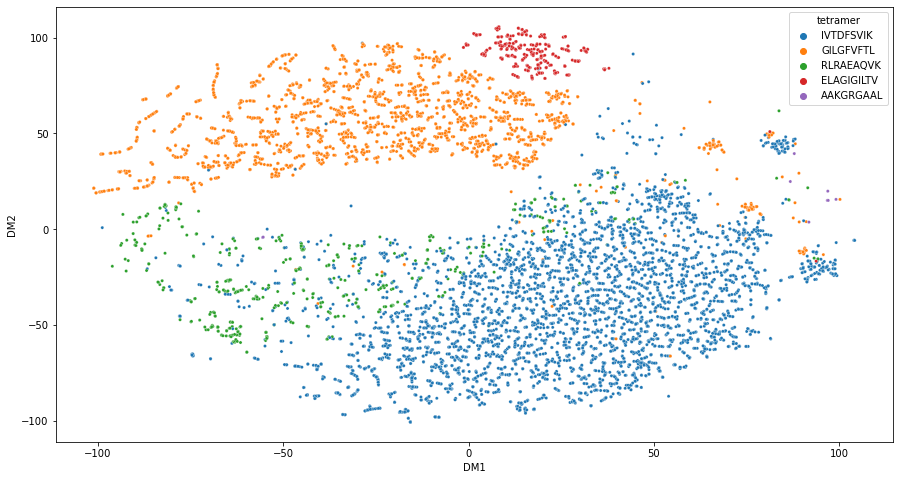

In [308]:
X_embedded_pca = tsne(pca_df,2,0,5)
tsne_pca_df = pd.DataFrame(data = X_embedded_pca, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_pca_df_data = tsne_pca_df.copy()
tsne_pca_df_data['barcode']=data_c_p.index
tsne_pca_df_data=tsne_pca_df_data.merge(barcode_tetramer, on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_pca_df_data[tsne_pca_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


#### TSNE on data

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


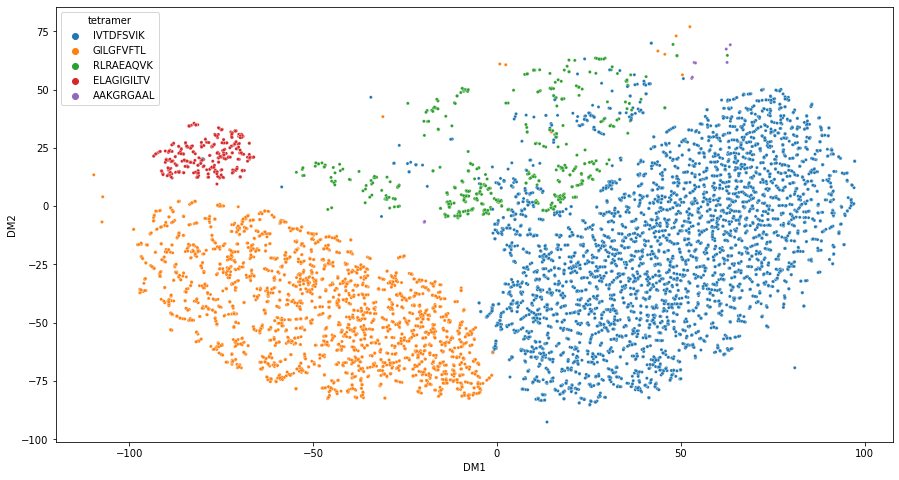

In [309]:
X_embedded = tsne(data_c_p,2,0,5)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_df_data = tsne_df.copy()
tsne_df_data['barcode']=data_c_p.index
tsne_df_data=tsne_df_data.merge(barcode_tetramer, on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


### Another normalization with total and avegage

In [221]:
#data_c_n = norm_logp_with_total_average(data_c_all, 'barcode','count')
#barcode_tetramer = data_c_n[['barcode','tetramer']].drop_duplicates()
#data_c_p = pivot_data(data_c_n)

In [222]:
#pca_df, pca_model = pca(data_c_p,50)
#pca_df_data = pca_df.copy()
#pca_df_data['barcode']=data_c_p.index

<AxesSubplot:>

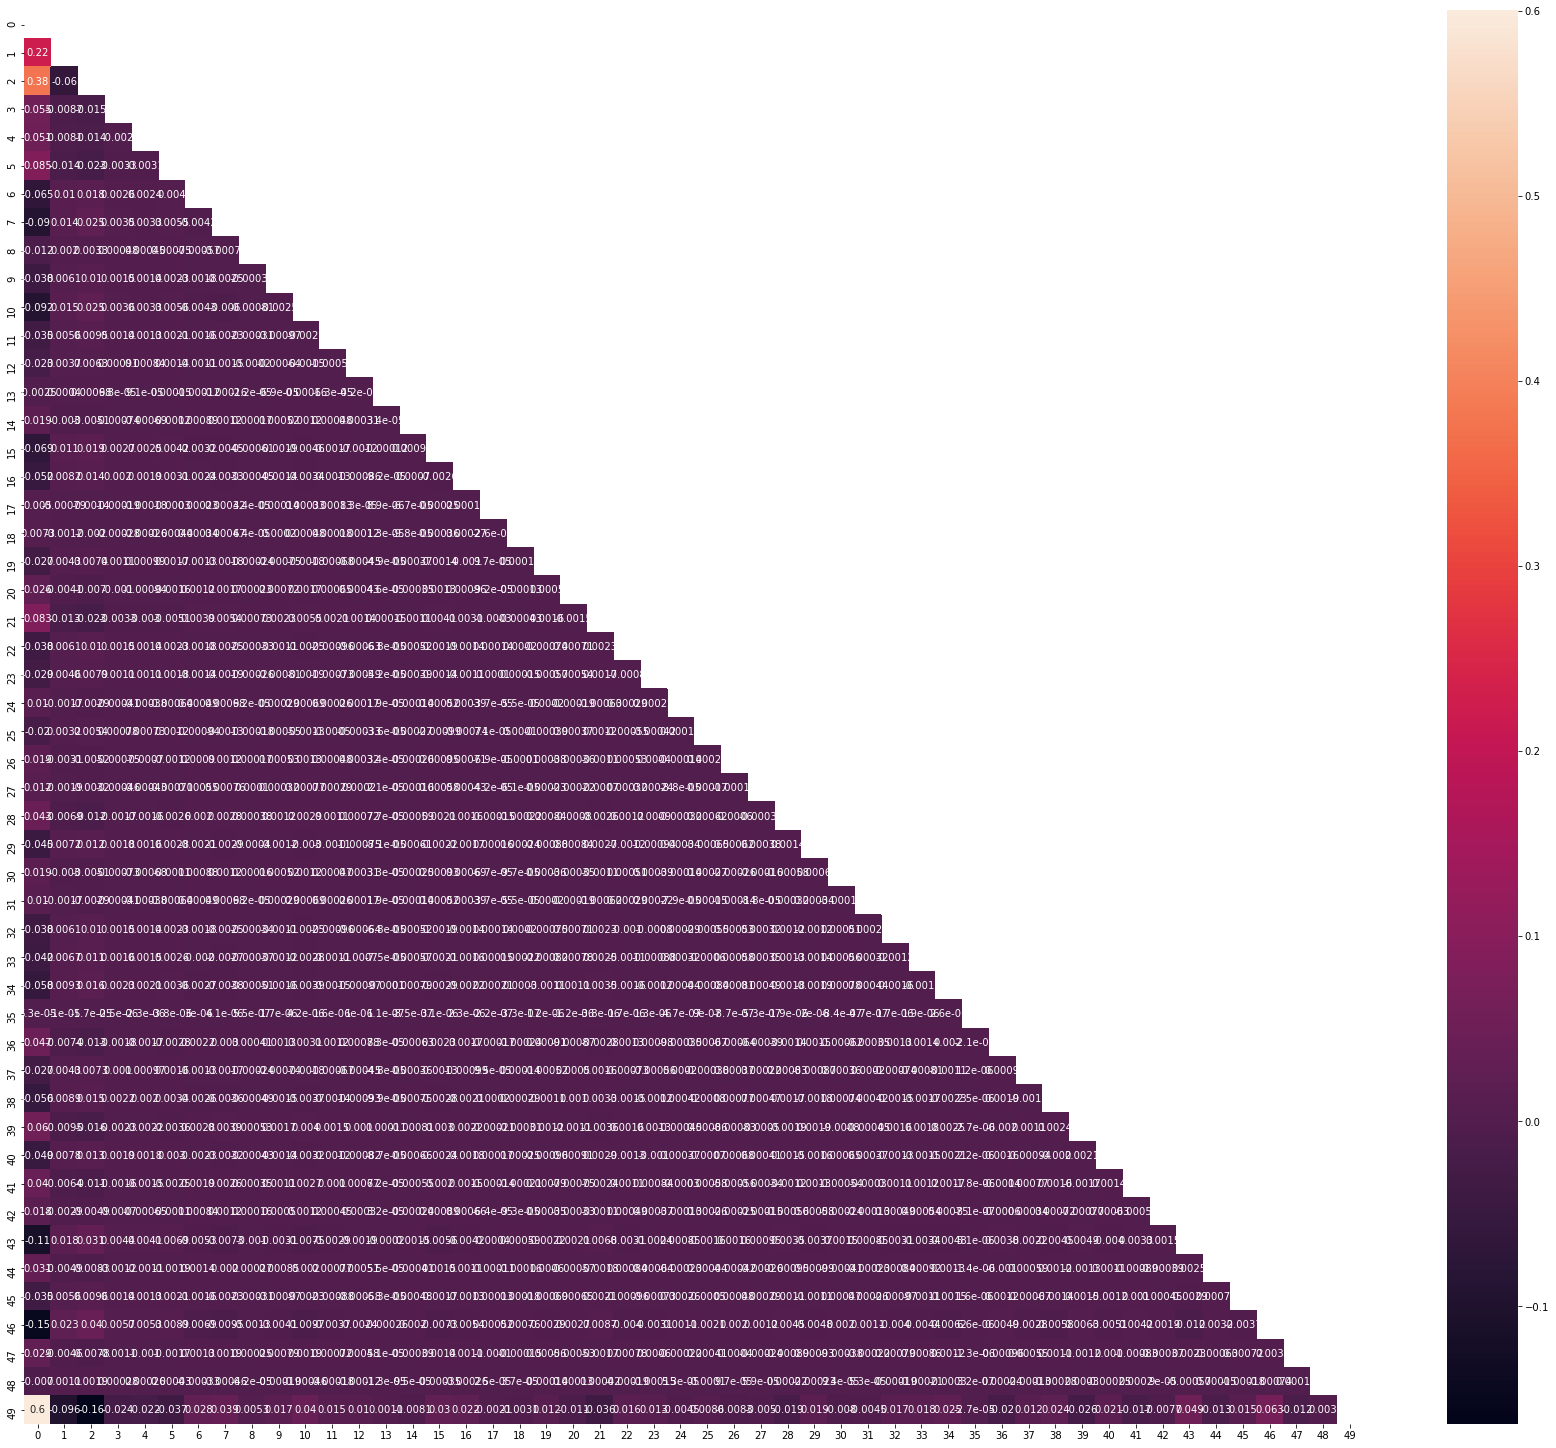

In [223]:
#components_scores = pd.DataFrame(pca_model.components_.T)
#corr_scores = components_scores.corr()

#matrix = np.triu(corr_scores)
#plt.figure(figsize=(30,26))
## using the upper triangle matrix as mask 
#sns.heatmap(corr_scores, annot=True, mask=matrix)

#### TSNE on pca

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


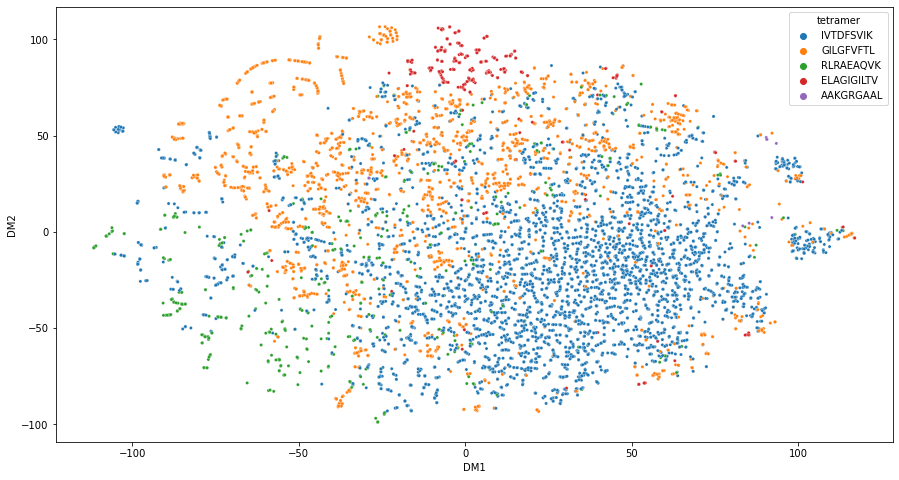

In [224]:
#X_embedded_pca = tsne(pca_df,2,0,5)
#tsne_pca_df = pd.DataFrame(data = X_embedded_pca, columns = ['DM1', 'DM2'])
#tsne_pca_df_data = tsne_pca_df.copy()
#tsne_pca_df_data['barcode']=data_c_p.index
#tsne_pca_df_data=tsne_pca_df_data.merge(barcode_tetramer, how='right', on='barcode')
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_pca_df_data[tsne_pca_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


#### TSNE on data

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


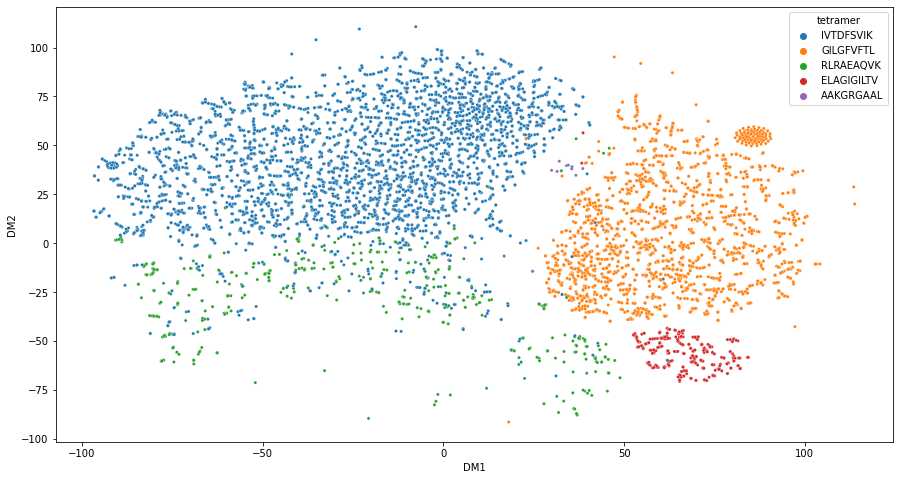

In [225]:
#X_embedded = tsne(data_c_p,2,0,5)
#tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])
#tsne_df_data = tsne_df.copy()
#tsne_df_data['barcode']=data_c_p.index
#tsne_df_data=tsne_df_data.merge(barcode_tetramer, how='right', on='barcode')
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


## Good bad clusters from tcr-emb

In [310]:
df_good_clusters_data = pd.read_csv('data_scripts/10x_good_clusters_emb.txt', sep='\t')
df_bad_clusters_data = pd.read_csv('data_scripts/10x_bad_clusters_emb.txt', sep='\t')
l_good_clusters = list(df_good_clusters_data['barcode'])
l_bad_clusters = list(df_bad_clusters_data['barcode'])

In [311]:
tsne_df_data['clusters'] = tsne_df_data['barcode'].apply(lambda x: 'good' if x in list(l_good_clusters) else 'false')

In [239]:
GILGFVFTL	10	1431	3058	1320	0.922432	0.106343	0.000000e+00
14	IVTDFSVIK	1	3745	6708	3722	0.993858	0.233273	0.000000e+00
8	AVFDRKSDAK

SyntaxError: invalid syntax (<ipython-input-239-d6d7aaf07b70>, line 1)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


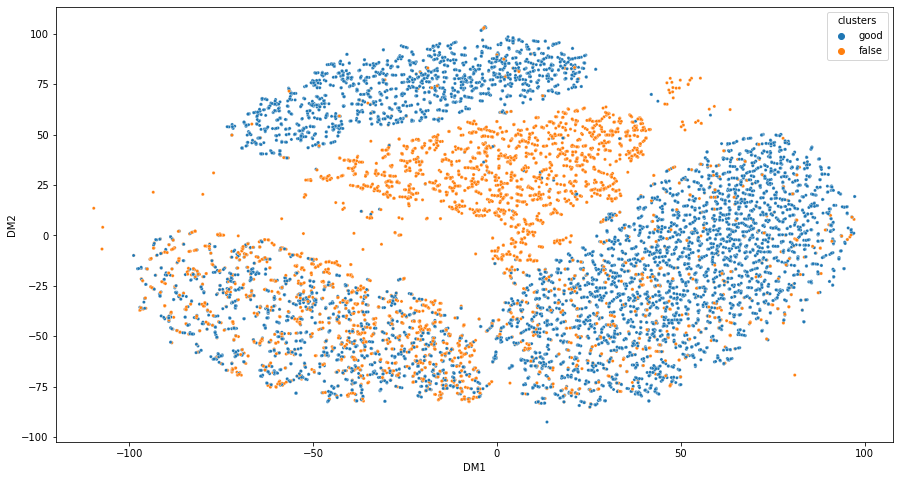

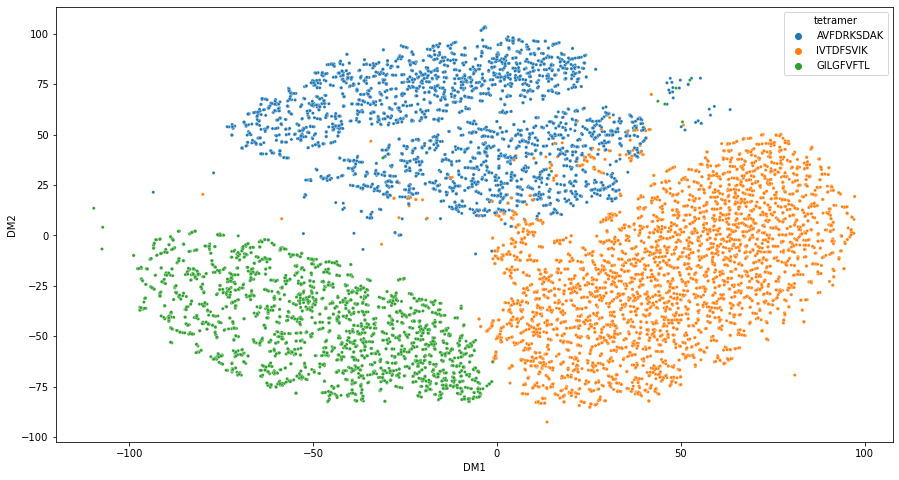

In [312]:


plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['GILGFVFTL','AVFDRKSDAK','IVTDFSVIK'])], hue='clusters',s=10)
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['GILGFVFTL','AVFDRKSDAK','IVTDFSVIK'])], hue='tetramer',s=10)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


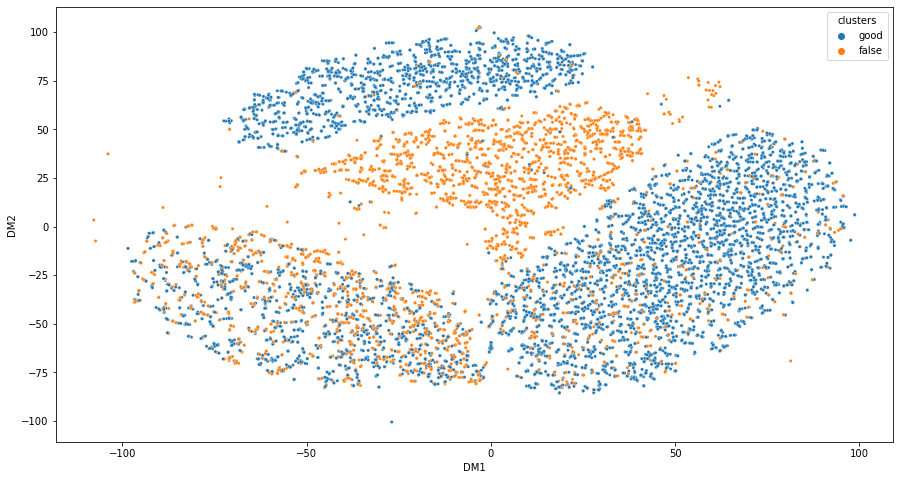

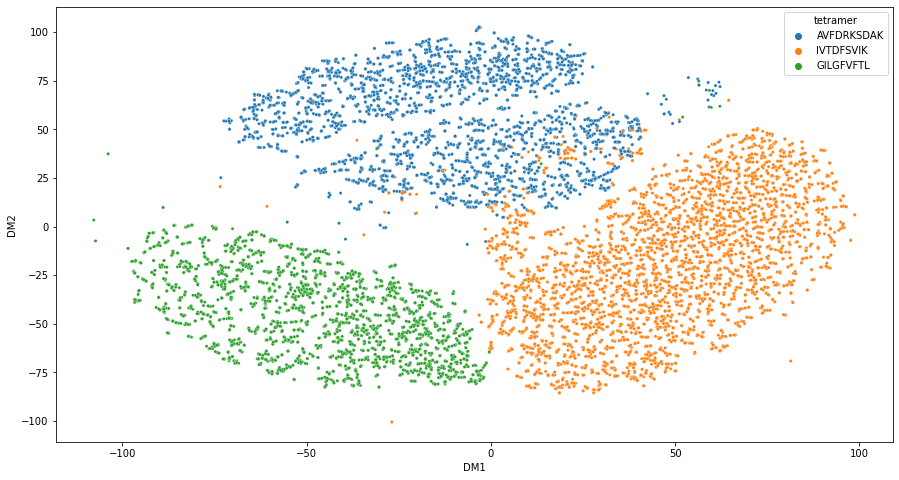

In [282]:


plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['GILGFVFTL','AVFDRKSDAK','IVTDFSVIK'])], hue='clusters',s=10)
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['GILGFVFTL','AVFDRKSDAK','IVTDFSVIK'])], hue='tetramer',s=10)

## Motifs as clusters

In [313]:
data_annot_preped = pd.read_csv('data_scripts/data_annot_preped.txt', sep='\t')
data_annot_preped

barcode  is_cell                     contig_id  \
0       AAACCTGAGACAAAGG-4     True   AAACCTGAGACAAAGG-4_contig_1   
1      AAACCTGAGACTGTAA-34     True  AAACCTGAGACTGTAA-34_contig_1   
2       AAACCTGAGAGCCCAA-5     True   AAACCTGAGAGCCCAA-5_contig_2   
3      AAACCTGAGAGCTGCA-24     True  AAACCTGAGAGCTGCA-24_contig_1   
4       AAACCTGAGAGGGATA-8     True   AAACCTGAGAGGGATA-8_contig_1   
...                    ...      ...                           ...   
28751  TTTGTCATCGAGCCCA-39     True  TTTGTCATCGAGCCCA-39_contig_1   
28752  TTTGTCATCGAGGTAG-13     True  TTTGTCATCGAGGTAG-13_contig_3   
28753  TTTGTCATCTCCAACC-24     True  TTTGTCATCTCCAACC-24_contig_1   
28754  TTTGTCATCTCCTATA-36     True  TTTGTCATCTCCTATA-36_contig_2   
28755  TTTGTCATCTGTCCGT-39     True  TTTGTCATCTGTCCGT-39_contig_1   

       high_confidence  length chain    v_gene d_gene   j_gene c_gene  \
0                 True     722   TRB  TRBV10-3  TRBD2  TRBJ2-1  TRBC2   
1                 True     688   TRB     TRBV2   None  TRBJ2-1  TRBC2   
2                 True     681   TRB   TRBV5-1  TRBD2  TRBJ2-3  TRBC2   
3                 True     551   TRB   TRBV5-1  TRBD1  TRBJ2-7  TRBC2   
4                 True     690   TRB   TRBV4-3  TRBD2  TRBJ2-1  TRBC2   
...                ...     ...   ...       ...    ...      ...    ...   
28751             True     686   TRB   TRBV7-9   None  TRBJ1-2  TRBC1   
28752             True     679   TRB    TRBV19   None  TRBJ1-5  TRBC1   
28753             True     685   TRB   TRBV7-3  TRBD1  TRBJ2-1  TRBC2   
28754             True     663   TRB   TRBV4-1  TRBD1  TRBJ2-7  TRBC2   
28755             True     955   TRB  TRBV23-1  TRBD2  TRBJ1-1  TRBC1   

       full_length productive               cdr3  \
0             True       True  CAISDPGLAGGGGEQFF   
1             True       True        CASDTPVGQFF   
2             True       True    CASSGGSISTDTQYF   
3             True       True     CASSGGQSSYEQYF   
4             True       True   CASSQDPAGGYNEQFF   
...            ...        ...                ...   
28751         True       True        CASSLGGEKTF   
28752         True       True      CASSTSNEQPQHF   
28753         True       True   CASSSDGQSSYNEQFF   
28754         True       True     CASSTGAGVNEQYF   
28755         True       True    CISAPAVPPAGKAFF   

                                                 cdr3_nt  reads  umis  \
0      TGTGCCATCAGTGACCCCGGACTAGCGGGAGGCGGGGGGGAGCAGT...  32237    18   
1                      TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC  15653    11   
2          TGCGCCAGCAGTGGCGGGAGTATTAGCACAGATACGCAGTATTTT  15764     7   
3             TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC   2769     2   
4       TGCGCCAGCAGCCAAGACCCAGCGGGGGGGTACAATGAGCAGTTCTTC  36552    18   
...                                                  ...    ...   ...   
28751                  TGTGCCAGCAGCTTAGGCGGCGAGAAGACCTTC  15744    13   
28752            TGTGCCAGTAGTACGTCGAATGAACAGCCCCAGCATTTT   2415     2   
28753   TGTGCCAGCAGCTCCGATGGACAGAGCTCCTACAATGAGCAGTTCTTC  10474     7   
28754         TGCGCCAGCAGTACAGGGGCTGGCGTGAACGAGCAGTACTTC   2490     2   
28755      TGTATCTCTGCGCCAGCAGTTCCCCCGGCCGGGAAAGCTTTCTTT   3915     4   

      raw_clonotype_id            raw_consensus_id    tetramer  count  
0          clonotype19     clonotype19_consensus_1  AVFDRKSDAK      2  
1        clonotype1318   clonotype1318_consensus_1  AVFDRKSDAK      5  
2        clonotype1319   clonotype1319_consensus_1  CLLGTYTQDV      1  
3        clonotype1320   clonotype1320_consensus_1    RAKFKQLL      1  
4        clonotype1321   clonotype1321_consensus_2   RLRAEAQVK      2  
...                ...                         ...         ...    ...  
28751   clonotype30335  clonotype30335_consensus_2  AVFDRKSDAK      3  
28752   clonotype30336  clonotype30336_consensus_2   GILGFVFTL     67  
28753   clonotype30337  clonotype30337_consensus_2   IVTDFSVIK      2  
28754   clonotype30338  clonotype30338_consensus_1  AVFDRKSDAK     14  
28755   clonotype30

In [314]:
tsne_df_data_gil = tsne_df_data[tsne_df_data['tetramer']=='GILGFVFTL']
tsne_df_data_gil = tsne_df_data_gil.merge(data_annot_preped[['barcode','tetramer','cdr3','count']],how='left',on=['barcode','tetramer'])
tsne_df_data_gil['cdr3_len'] = tsne_df_data_gil['cdr3'].apply(len)

In [315]:
tsne_df_data_gil

DM1        DM2              barcode   tetramer clusters  \
0    -89.778870 -19.538052  AAACCTGAGTGGGTTG-17  GILGFVFTL    false   
1    -72.122925 -63.384132   AAACCTGCAAACCCAT-9  GILGFVFTL     good   
2    -48.192726 -39.093445  AAACCTGCAAGAGGCT-17  GILGFVFTL     good   
3    -53.177292 -71.345680  AAACCTGCACATTAGC-21  GILGFVFTL    false   
4    -40.599857 -33.182804  AAACCTGCACTTCGAA-25  GILGFVFTL     good   
...         ...        ...                  ...        ...      ...   
2598 -21.831108 -32.676453  TTTGGTTCAGCTATTG-30  GILGFVFTL    false   
2599 -40.706726 -79.307823  TTTGGTTGTTAGGGTG-10  GILGFVFTL    false   
2600 -61.415005 -74.077370   TTTGGTTTCAGCTGGC-9  GILGFVFTL     good   
2601 -13.599187 -75.943901  TTTGTCAGTAAACCTC-30  GILGFVFTL     good   
2602 -70.095520 -68.956039  TTTGTCATCGAGGTAG-13  GILGFVFTL    false   

                 cdr3  count  cdr3_len  
0     CASTDFGSGANVLTF     45        15  
1       CASSTRSSYEQYF     54        13  
2       CASSIRSAYEQYF     95        13  
3       CASSSRAGGEQYF    140        13  
4       CASSIRASYEQYF     64        13  
...               ...    ...       ...  
2598    CASSIRSQETQYF     30        13  
2599   CASSFGQGAEKLFF    265        14  
2600    CASSIRSAYEQYF    112        13  
2601    CASSVRSSYEQYF    136        13  
2602    CASSTSNEQPQHF     67        13  

[2603 rows x 8 columns]

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


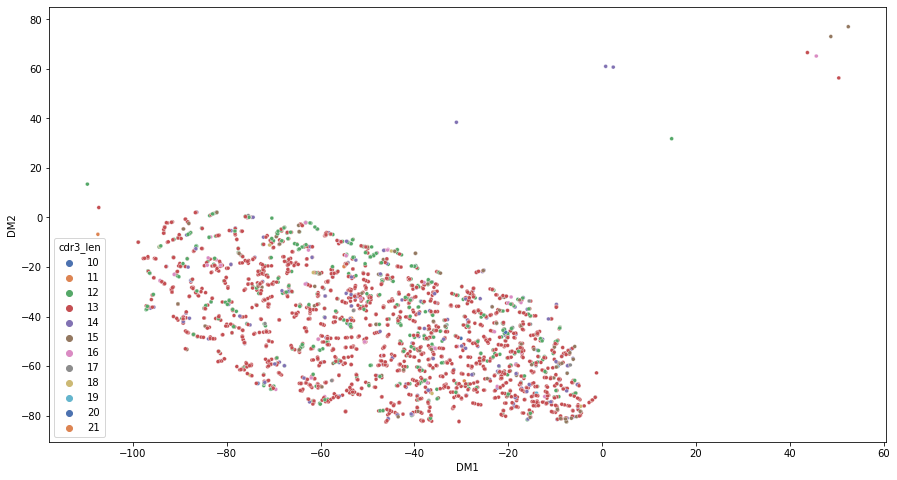

In [316]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data_gil,hue='cdr3_len',s=15,palette="deep")

In [321]:
tsne_df_data_gil[(tsne_df_data_gil['cdr3_len']==13)&(tsne_df_data_gil['clusters']=='good')].drop_duplicates('cdr3')


DM1        DM2              barcode   tetramer clusters  \
1    -72.122925 -63.384132   AAACCTGCAAACCCAT-9  GILGFVFTL     good   
2    -48.192726 -39.093445  AAACCTGCAAGAGGCT-17  GILGFVFTL     good   
4    -40.599857 -33.182804  AAACCTGCACTTCGAA-25  GILGFVFTL     good   
9    -35.483356 -30.003084  AAACCTGTCGCACTCT-17  GILGFVFTL     good   
28   -35.914730 -42.176895  AAAGCAATCTGGTATG-32  GILGFVFTL     good   
90   -80.510345 -57.099258  AAGCCGCAGGAACTGC-13  GILGFVFTL     good   
107  -56.139416 -10.582067  AAGGCAGTCTGACCTC-24  GILGFVFTL     good   
111  -35.916798 -45.530399  AAGTCTGAGCCGGTAA-12  GILGFVFTL     good   
170  -25.864941 -75.628891  ACCAGTACATACTCTT-26  GILGFVFTL     good   
185  -50.342148 -13.922559  ACCGTAAGTCGAGATG-40  GILGFVFTL     good   
232  -28.502430 -63.449223  ACGCCAGGTACTTAGC-22  GILGFVFTL     good   
250  -62.287449 -40.855618  ACGGGCTAGTAAGTAC-10  GILGFVFTL     good   
304  -19.812031 -56.592262   ACTGTCCTCCAAGTAC-9  GILGFVFTL     good   
499  -61.550919 -52.306168  ATAGACCTCATCTGTT-34  GILGFVFTL     good   
502  -50.204735 -25.632500  ATCACGAGTCCGTGAC-35  GILGFVFTL     good   
519  -38.577816 -55.115810  ATCCACCAGGCGACAT-13  GILGFVFTL     good   
573  -90.683296 -40.704647  ATTCTACAGCCATCGC-13  GILGFVFTL     good   
623  -49.053982 -28.588448  CAAGTTGCAGCATGAG-28  GILGFVFTL     good   
640  -24.996599 -65.157829  CACACCTAGATAGTCA-30  GILGFVFTL     good   
728  -19.090145 -74.834274   CAGTAACAGGCTCAGA-5  GILGFVFTL     good   
791  -57.321514 -52.990002   CATGCCTAGTCGATAA-6  GILGFVFTL     good   
966  -88.412659 -16.627125  CGATCGGCAGACACTT-36  GILGFVFTL     good   
1003 -45.739441 -23.449207  CGCTATCAGTAGCCGA-11  GILGFVFTL     good   
1072 -36.184906 -31.401241  CGTCACTAGCACCGCT-16  GILGFVFTL     good   
1148 -95.581139 -24.348888  CTACACCCAAGTCTGT-27  GILGFVFTL     good   
1169 -92.971909 -19.829853   CTAGAGTCACTACAGT-2  GILGFVFTL     good   
1192 -69.181496 -58.787754  CTCAGAAAGAGCTATA-32  GILGFVFTL     good   
1333 -25.751812 -38.784462  CTTGGCTCATCCTAGA-31  GILGFVFTL     good   
1359 -17.992868 -53.161701  GAAATGAGTGAAAGAG-22  GILGFVFTL     good   
1717 -39.558075 -67.719398   GGACAAGTCGCGTTTC-7  GILGFVFTL     good   
1774 -68.820946 -41.345982   GGCGTGTGTACAGACG-6  GILGFVFTL     good   
1865 -39.564217 -66.046127  GTAACTGGTTCGTCTC-36  GILGFVFTL     good   
2220 -75.706825 -60.323948  TCATTACCAGCTTAAC-12  GILGFVFTL     good   
2446  -4.864857 -80.150452  TGGTTAGCAGCTGTAT-36  GILGFVFTL     good   

               cdr3  count  cdr3_len  
1     CASSTRSSYEQYF     54        13  
2     CASSIRSAYEQYF     95        13  
4     CASSIRASYEQYF     64        13  
9     CASSIRSSYEQYF     53        13  
28    CASSVRSSYEQYF     34        13  
90    CASSTRAAYEQYF    104        13  
107   CASSTRSGWEQYF     38        13  
111   CASSGRSGYEQYF     68        13  
170   CASSTRSAYEQYF    163        13  
185   CASSFRSSYEQYF     20        13  
232   CASSIRSTYEQYF    130        13  
250   CASSIRGAYEQYF    224        13  
304   CASSQRSSYEQYF    170        13  
499   CASSVRSAYEQYF     51        13  
502   CASSTRSGYEQYF     93        13  
519   CASSMRSSYEQYF    188        13  
573   CASSMRASYEQYF     95        13  
623   CASSMRASVEQYF     71        13  
640   CASSIRSGNEQYF    182        13  
728   CASSLRAGIEQYF    336        13  
791   CASSSRSGVEQYF    138        13  
966   CASSIRSNYEQYF     54        13  
1003  CASSLRSSYEQYF     86        13  
1072  CASSMRSAYEQYF     58        13  
1148  CASSSRSAYEQYF     53        13  
1169  CASSIRSGYEQYF     47        13  
1192  CASSIRAAYEQYF     54        13  
1333  CASSHRSSYEQYF     58        13  
1359  CASSESISYEQYF    143        13  
1717  CASSTRASEGQYF    226        13  
1774  CASSSRSSYEQYF     65        13  
1865  CASSSRSGSEQYF    100        13  
2220  CASSDRSGTEQYF    136        13  
2446  CASSARSSYEQYF     55        13

In [317]:
tsne_df_data_avf = tsne_df_data[tsne_df_data['tetramer']=='AVFDRKSDAK']
tsne_df_data_avf = tsne_df_data_avf.merge(data_annot_preped[['barcode','tetramer','cdr3','count']],how='left',on=['barcode','tetramer'])
tsne_df_data_avf['cdr3_len'] = tsne_df_data_avf['cdr3'].apply(len)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1, 'only cdr3_len = 14')

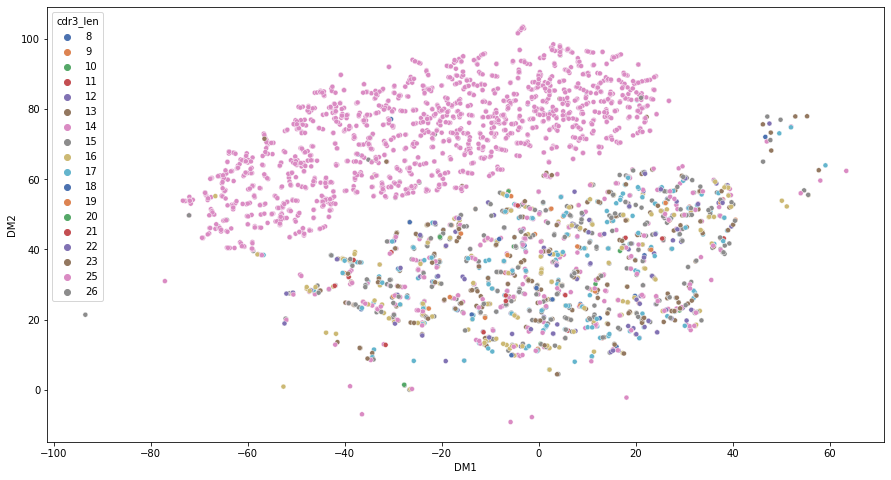

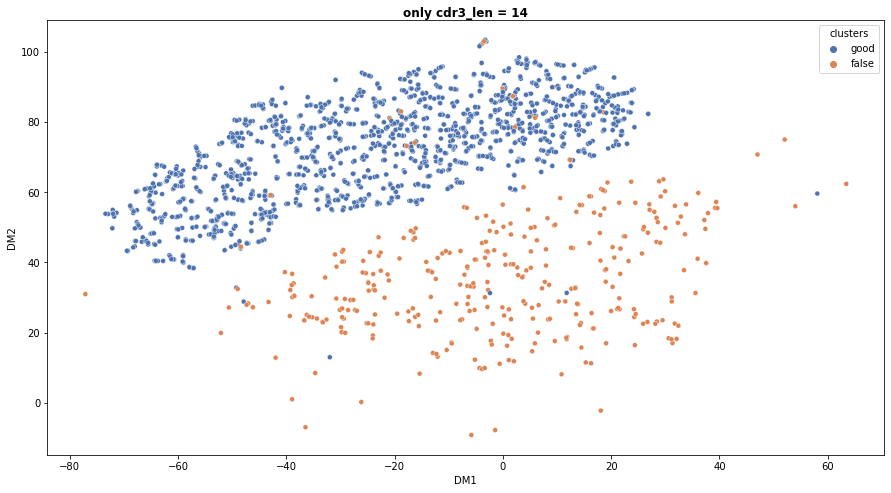

In [318]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data_avf,hue='cdr3_len',s=25,palette="deep")
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data_avf[tsne_df_data_avf['cdr3_len']==14],hue='clusters',s=25,palette="deep")
ax.text(x=0.5, y=1, s='only cdr3_len = 14', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)

In [319]:
tsne_df_data_avf[(tsne_df_data_avf['cdr3_len']==14)&(tsne_df_data_avf['clusters']=='good')].drop_duplicates('cdr3')

DM1        DM2              barcode    tetramer clusters  \
0    -40.172886  80.373238  AAACCTGAGATTACCC-16  AVFDRKSDAK     good   
1214  11.778376  31.325371  CGAACATCATTTCACT-36  AVFDRKSDAK     good   

                cdr3  count  cdr3_len  
0     CASSLYSATGELFF    451        14  
1214  CASSIADSNYEQYF      6        14

### Clustering

In [52]:
#Clustering
#Kmeans
n_tetra = len(barcode_tetramer['tetramer'].drop_duplicates())
labels = data_c_p_tetramer['tetramer']
kmeans = KMeans(n_clusters=n_tetra, random_state=0).fit(data_c_p)

In [53]:
labels

0        AVFDRKSDAK
1         IVTDFSVIK
2        AVFDRKSDAK
3         GILGFVFTL
4         IVTDFSVIK
            ...    
12752    AVFDRKSDAK
12753    AVFDRKSDAK
12754     AAKGRGAAL
12755     GILGFVFTL
12756    AVFDRKSDAK
Name: tetramer, Length: 12757, dtype: object

In [54]:
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data, clusters], axis = 1)
df_kmeans

DM1        DM2              barcode    tetramer  cluster
0     -20.469307 -59.509323  AAACCTGAGATTACCC-16  AVFDRKSDAK       14
1      57.532051  19.180311  AAACCTGAGGGAGTAA-40   IVTDFSVIK       25
2     -49.449821 -48.409824  AAACCTGAGGTGCACA-13  AVFDRKSDAK       17
3     -47.891056  46.545906  AAACCTGAGTGGGTTG-17   GILGFVFTL       37
4      27.836912  -7.767010  AAACCTGAGTTTAGGA-39   IVTDFSVIK        4
...          ...        ...                  ...         ...      ...
12752   2.891776 -28.649307  TTTGTCAGTGATAAGT-22  AVFDRKSDAK       11
12753 -34.491100 -28.170109  TTTGTCAGTTACCGAT-20  AVFDRKSDAK       16
12754 -13.991593  18.594116  TTTGTCATCAGGTAAA-40   AAKGRGAAL       27
12755 -32.617928  34.271870  TTTGTCATCGAGGTAG-13   GILGFVFTL       37
12756 -25.542187 -11.434472  TTTGTCATCTCCTATA-36  AVFDRKSDAK        0

[12757 rows x 5 columns]

In [39]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_,kmeans.n_clusters]
    
    results += [kmeans.n_init]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [40]:
n_tetra = len(barcode_tetramer['tetramer'].drop_duplicates())
labels = data_c_p_tetramer['tetramer']

n_start = 4
n_end = n_tetra

print(82 * "_")
print("init\tn_init\t\ttime\tinertia\tn_clust\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

n_init_param = 4
random_state_param = 0

init_param = "k-means++"
for i in range(n_start,n_end+1):
    kmeans = KMeans(init=init_param, n_clusters=i, n_init=n_init_param, random_state=0)
    bench_k_means(kmeans=kmeans, name=init_param, data=data_c_p, labels=labels)

init_param = "random"
for i in range(n_start,n_end+1):
    kmeans = KMeans(init=init_param, n_clusters=i, n_init=n_init_param, random_state=0)
    bench_k_means(kmeans=kmeans, name=init_param, data=data_c_p, labels=labels)

n_init_param = 20
random_state_param = 0

init_param = "k-means++"
for i in range(n_start,n_end+1):
    kmeans = KMeans(init=init_param, n_clusters=i, n_init=n_init_param, random_state=0)
    bench_k_means(kmeans=kmeans, name=init_param, data=data_c_p, labels=labels)

init_param = "random"
for i in range(n_start,n_end+1):
    kmeans = KMeans(init=init_param, n_clusters=i, n_init=n_init_param, random_state=0)
    bench_k_means(kmeans=kmeans, name=init_param, data=data_c_p, labels=labels)
print(82 * "_")

__________________________________________________________________________________
init	n_init		time	inertia	n_clust	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.159s	567320	4	4.000	0.238	0.347	0.282	0.219	0.280
k-means++	0.266s	558097	5	4.000	0.241	0.325	0.277	0.216	0.274
k-means++	0.265s	549497	6	4.000	0.244	0.308	0.272	0.217	0.269
k-means++	0.328s	543213	7	4.000	0.329	0.350	0.339	0.296	0.335
k-means++	0.335s	533535	8	4.000	0.293	0.310	0.301	0.277	0.297
k-means++	0.292s	525974	9	4.000	0.406	0.382	0.393	0.320	0.389
k-means++	0.335s	518456	10	4.000	0.402	0.352	0.375	0.323	0.370
k-means++	0.375s	507698	11	4.000	0.483	0.403	0.440	0.341	0.435
k-means++	0.292s	499542	12	4.000	0.473	0.393	0.429	0.331	0.424
k-means++	0.348s	497337	13	4.000	0.312	0.265	0.287	0.199	0.280
k-means++	0.362s	493803	14	4.000	0.344	0.265	0.299	0.235	0.293
k-means++	0.278s	486715	15	4.000	0.410	0.310	0.353	0.264	0.346
k-means++	0.371s	477579	16	4.000	0.411	0.305	0.350	0.261	0.343
k-means++	0.354s	471454	17	4.000	

In [41]:
#Clustering
#Kmeans
n_clus = 12
init_param = "random"
n_init_param = 20
random_state_param = 0
labels = data_c_p_tetramer['tetramer']
kmeans = KMeans(init=init_param, n_clusters=n_clus, n_init=n_init_param, random_state=random_state_param).fit(data_c_p)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


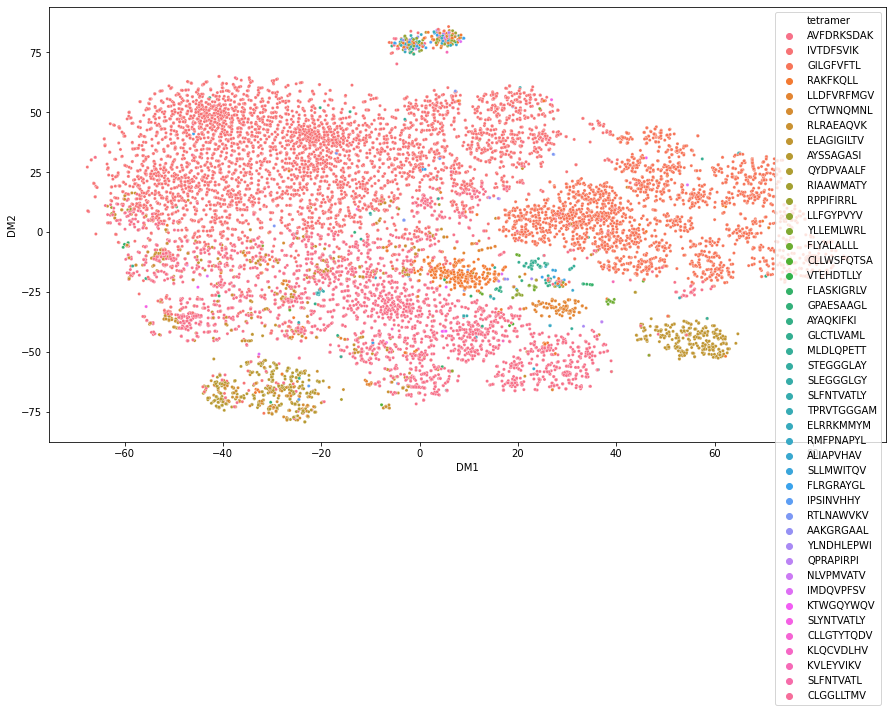

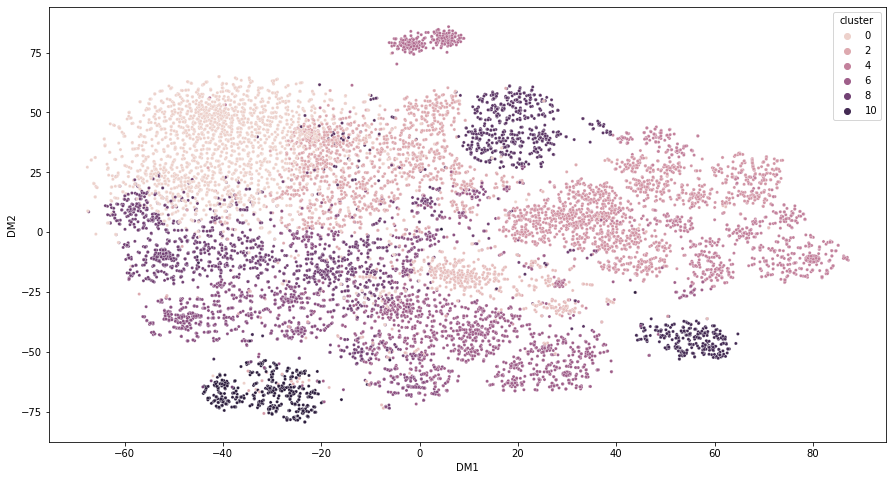

In [42]:
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data, clusters], axis = 1)

plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='tetramer',s=10)
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='cluster',s=10)

In [43]:
counts_tetras = barcode_tetramer.groupby('tetramer').count()
counts_tetras.sort_values('barcode')

barcode
tetramer           
VTEHDTLLY         1
CLGGLLTMV         1
CLLGTYTQDV        1
SLYNTVATLY        2
SLFNTVATL         2
KLQCVDLHV         2
CLLWSFQTSA        3
NLVPMVATV         3
SLLMWITQV         4
ALIAPVHAV         4
TPRVTGGGAM        4
SLEGGGLGY         4
RIAAWMATY         4
IPSINVHHY         5
KVLEYVIKV         6
RMFPNAPYL         6
IMDQVPFSV         6
YLNDHLEPWI        6
YLLEMLWRL         8
STEGGGLAY         9
KTWGQYWQV         9
AAKGRGAAL        10
QYDPVAALF        11
QPRAPIRPI        12
RTLNAWVKV        14
MLDLQPETT        15
GPAESAAGL        15
FLASKIGRLV       19
LLFGYPVYV        21
FLYALALLL        23
ELRRKMMYM        23
FLRGRAYGL        26
SLFNTVATLY       28
AYAQKIFKI        29
GLCTLVAML        44
RPPIFIRRL        55
CYTWNQMNL        93
LLDFVRFMGV      157
AYSSAGASI       322
ELAGIGILTV      328
RAKFKQLL        356
RLRAEAQVK       491
GILGFVFTL      2603
AVFDRKSDAK     3320
IVTDFSVIK      4652

In [44]:
counts_tetras_filtered = counts_tetras[counts_tetras['barcode']>30]
counts_tetras_filtered = list(counts_tetras_filtered.index)
counts_tetras_filtered

['AVFDRKSDAK',
 'AYSSAGASI',
 'CYTWNQMNL',
 'ELAGIGILTV',
 'GILGFVFTL',
 'GLCTLVAML',
 'IVTDFSVIK',
 'LLDFVRFMGV',
 'RAKFKQLL',
 'RLRAEAQVK',
 'RPPIFIRRL']

In [45]:
barcode_tetramer_v2 = barcode_tetramer[barcode_tetramer['tetramer'].isin(counts_tetras_filtered)]

data_c_p_v2 = data_c_p[data_c_p.index.isin(barcode_tetramer_v2['barcode'])]
data_c_p_tetramer_v2 = data_c_p_v2.copy()
data_c_p_tetramer_v2 = data_c_p_tetramer_v2.merge(barcode_tetramer_v2, on='barcode')


barcode_tetramer_v2

barcode    tetramer
3       AAACCTGAGATTACCC-16  AVFDRKSDAK
23      AAACCTGAGGGAGTAA-40   IVTDFSVIK
73      AAACCTGAGGTGCACA-13  AVFDRKSDAK
78      AAACCTGAGTGGGTTG-17   GILGFVFTL
80      AAACCTGAGTTTAGGA-39   IVTDFSVIK
...                     ...         ...
212247  TTTGTCAGTGACGCCT-18   IVTDFSVIK
212250  TTTGTCAGTGATAAGT-22  AVFDRKSDAK
212281  TTTGTCAGTTACCGAT-20  AVFDRKSDAK
212320  TTTGTCATCGAGGTAG-13   GILGFVFTL
212322  TTTGTCATCTCCTATA-36  AVFDRKSDAK

[12421 rows x 2 columns]

In [46]:
n_tetra = len(barcode_tetramer_v2['tetramer'].drop_duplicates())
labels = barcode_tetramer_v2['tetramer']

n_start = 4
n_end = n_tetra*2

print(82 * "_")
print("init\t\ttime\tinertia\tn_clust\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

for i in range(n_start,n_end+1):
    kmeans = KMeans(init="random", n_clusters=i, n_init=20, random_state=0)
    bench_k_means(kmeans=kmeans, name="random", data=data_c_p_v2, labels=labels)
    
print(82 * "_")

__________________________________________________________________________________
init		time	inertia	n_clust	homo	compl	v-meas	ARI	AMI	silhouette
random   	0.740s	553660	4	20.000	0.270	0.357	0.307	0.243	0.307
random   	0.842s	543081	5	20.000	0.405	0.438	0.421	0.378	0.420
random   	1.018s	533037	6	20.000	0.366	0.386	0.376	0.329	0.375
random   	1.011s	526880	7	20.000	0.357	0.348	0.352	0.308	0.351
random   	1.055s	520855	8	20.000	0.347	0.316	0.331	0.291	0.330
random   	1.016s	512497	9	20.000	0.344	0.300	0.320	0.280	0.319
random   	1.077s	507189	10	20.000	0.333	0.273	0.300	0.257	0.299
random   	1.185s	500405	11	20.000	0.423	0.327	0.369	0.283	0.367
random   	1.236s	495794	12	20.000	0.408	0.302	0.347	0.255	0.346
random   	1.279s	490017	13	20.000	0.381	0.271	0.317	0.246	0.315
random   	1.362s	483591	14	20.000	0.331	0.237	0.276	0.216	0.274
random   	1.231s	476517	15	20.000	0.417	0.284	0.338	0.223	0.336
random   	1.235s	471610	16	20.000	0.490	0.316	0.384	0.264	0.382
random   	1.393s	462502	17	

In [47]:
tsne_df_data

DM1        DM2              barcode    tetramer
0      16.211845  -9.655579  AAACCTGAGATTACCC-16  AVFDRKSDAK
1     -23.872469  43.797531  AAACCTGAGGGAGTAA-40   IVTDFSVIK
2      30.600014 -59.403248  AAACCTGAGGTGCACA-13  AVFDRKSDAK
3      75.373055 -16.363150  AAACCTGAGTGGGTTG-17   GILGFVFTL
4     -42.612099   0.547552  AAACCTGAGTTTAGGA-39   IVTDFSVIK
...          ...        ...                  ...         ...
12752 -62.422657   7.274702  TTTGTCAGTGATAAGT-22  AVFDRKSDAK
12753  10.694508  14.765654  TTTGTCAGTTACCGAT-20  AVFDRKSDAK
12754  17.896761 -19.695801  TTTGTCATCAGGTAAA-40   AAKGRGAAL
12755  58.999672 -18.732058  TTTGTCATCGAGGTAG-13   GILGFVFTL
12756 -46.832256 -38.065563  TTTGTCATCTCCTATA-36  AVFDRKSDAK

[12757 rows x 4 columns]

In [ ]:
X_embedded = tsne(data_c_p_v2,2,0,25)
tsne_df_v2 = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_df_data_v2 = tsne_df_v2.copy()
tsne_df_data_v2['barcode']=data_c_p_v2.index
tsne_df_data_v2=tsne_df_data_v2.merge(barcode_tetramer_v2, how='right', on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data_v2, hue='tetramer',s=10)



In [ ]:
#Clustering
#Kmeans
n_clus = 5
init_param = "random"
n_init_param = 20
random_state_param = 0
labels = barcode_tetramer_v2['tetramer']
labels = data_c_p_tetramer['tetramer']
kmeans = KMeans(init=init_param, n_clusters=n_clus, n_init=n_init_param, random_state=random_state_param).fit(data_c_p_v2)

In [ ]:
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data_v2, clusters], axis = 1)
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data_v2, hue='tetramer',s=10)
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='cluster',s=10)

### AgglomerativeClustering

In [ ]:
#Clustering
#AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
n_tetra = len(barcode_tetramer['tetramer'].drop_duplicates())
labels = data_c_p_tetramer['tetramer']
agglomerative = AgglomerativeClustering(n_clusters=n_tetra, linkage="ward").fit(data_c_p)

In [ ]:
clusters = pd.DataFrame(agglomerative.labels_, columns= ['cluster'])
df_agglomerative = pd.concat([tsne_df_data, clusters], axis = 1)
df_agglomerative

In [90]:
def bench_agglomerative(agglomerative, name, data, labels):
    t0 = time()
    estimator = make_pipeline(StandardScaler(), agglomerative).fit(data)
    fit_time = time() - t0
    results = [name, fit_time,agglomerative.n_clusters]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
 #   results += [
 #       metrics.silhouette_score(
 #           data,
 #           estimator[-1].labels_,
 #           metric="euclidean",
 #           sample_size=300,
 #       )
 #   ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"#\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [ ]:

n_tetra = len(barcode_tetramer['tetramer'].drop_duplicates())
labels = barcode_tetramer['tetramer']

n_start = 4
n_end = n_tetra*2

print(82 * "_")
print("init\t\ttime\tn_clust\thomo\tcompl\tv-meas\tARI\tAMI")

linkage = "single"
for i in range(n_start,n_end+1):
    agglomerative = AgglomerativeClustering(n_clusters=i, linkage=linkage)
    bench_agglomerative(agglomerative=agglomerative, name=linkage, data=data_c_p, labels=labels)

linkage = "complete"
for i in range(n_start,n_end+1):
    agglomerative = AgglomerativeClustering(n_clusters=i, linkage=linkage)
    bench_agglomerative(agglomerative=agglomerative, name=linkage, data=data_c_p, labels=labels)
    
linkage = "average"
for i in range(n_start,n_end+1):
    agglomerative = AgglomerativeClustering(n_clusters=i, linkage=linkage)
    bench_agglomerative(agglomerative=agglomerative, name=linkage, data=data_c_p, labels=labels)
    
linkage = "ward"
for i in range(n_start,n_end+1):
    agglomerative = AgglomerativeClustering(n_clusters=i, linkage=linkage)
    bench_agglomerative(agglomerative=agglomerative, name=linkage, data=data_c_p, labels=labels)
print(82 * "_")

__________________________________________________________________________________
init		time	n_clust	homo	compl	v-meas	ARI	AMI
single   	6.956s	4	0.001	0.428	0.001	0.000	0.001
single   	6.946s	5	0.001	0.345	0.001	0.000	0.001
single   	6.942s	6	0.001	0.394	0.002	0.000	0.001
single   	6.944s	7	0.001	0.387	0.002	0.000	0.001
single   	6.950s	8	0.001	0.350	0.002	0.000	0.001
single   	6.962s	9	0.001	0.379	0.003	0.001	0.002
single   	6.946s	10	0.002	0.405	0.003	0.001	0.002
single   	6.948s	11	0.002	0.377	0.003	0.001	0.002
single   	6.959s	12	0.002	0.375	0.004	0.001	0.002
single   	6.951s	13	0.002	0.403	0.004	0.001	0.003
single   	6.957s	14	0.003	0.417	0.005	0.001	0.003
single   	6.957s	15	0.003	0.413	0.005	0.001	0.003
single   	6.972s	16	0.003	0.394	0.005	0.001	0.003
single   	6.974s	17	0.003	0.410	0.006	0.001	0.004
single   	6.967s	18	0.003	0.411	0.006	0.001	0.004
single   	6.966s	19	0.003	0.396	0.007	0.001	0.004
single   	6.960s	20	0.004	0.410	0.007	0.001	0.004
single   	6.961s	21	0.004	0.